#### Simiple topic modeling with GPT

In [2]:
from docx import Document
import os
import pandas as pd
import sys
from tqdm import tqdm
sys.path.insert(0,'../../libs')
from utils import load_json
import openai
from llm_utils import BSAgent_legacy
import json
key = load_json('/home/chuang/Dev/Keys/openai_key.json') 
os.environ['OPENAI_API_KEY'] = key['ChatGPT']['API_KEY']
openai.api_key  = os.getenv('OPENAI_API_KEY')

...currently using old version of openai


In [3]:
llm_agent  = BSAgent_legacy(model="gpt-3.5-turbo-1106", 
                    temperature=0)
## just run one test, make sure the api works 
pt = {'System':'You are a helpful assistant.',
      'Human':'What is your name?'}
res = llm_agent.get_response_content(prompt_template=pt)
print(res)  


I am a language model AI created by OpenAI, and I don't have a personal name. You can just call me "Assistant." How can I assist you today?


In [11]:
doc_folder= '/data/chuang/temp/Text'
files = os.listdir(doc_folder)

all_ps = []
for f in files:
    year = f[:4]
    doc_path = os.path.join(doc_folder,f)
    doc = Document(doc_path)
    # Extracting text from the document
    doc_text = [paragraph.text for paragraph in doc.paragraphs if paragraph.text]
    doc_text = [p for p in doc_text if len(p)>10]
    s_len = [len(p.split()) for p in doc_text]
    ys = [year]*len(s_len)
    res = list(zip(ys,doc_text,s_len))
    all_ps.extend(res)

p_df = pd.DataFrame(all_ps,columns=['year','para','count'])

In [12]:
p_df.head()

,year,para,count
0,2017,BRICS Leaders Xiamen Declaration,4
1,2017,"September 4, 2017, Xiamen, China\n",5
2,2017,"We, the Leaders of the Federative Republic of ...",85
3,2017,We reiterate that it is the overarching object...,94
4,2017,Our cooperation since 2006 has fostered the BR...,111


In [50]:
llm_agent  = BSAgent_legacy(model="gpt-4-1106-preview", 
                    temperature=0)

In [51]:
year = 2009
content = '\n'.join(p_df[p_df['year']=='2009']['para'])
#print(content)

In [52]:
human_input_template = """
Below is a statement provided by BRIC Countries' Leaders. 
Please, identify the main topics mentioned in the document 

Return a list of 5-10 topics. 
Output is a JSON list with the following format
[
    {{"topic_name": "<topic1>", "topic_description": "<topic_description1>"}}, 
    {{"topic_name": "<topic2>", "topic_description": "<topic_description2>"}},
    ...
]
only return JSON object and nothing else

provided statement:
{CONTENT}
"""

In [44]:
#print(human_input_template.format(CONTENT=content))

In [53]:
## just run one test, make sure the api works 
pt = {'System':'You are an experienced economist working at the IMF. Your job is to summarize lengthy documents and provide useful insights',
      'Human':human_input_template.format(CONTENT=content)}
res = llm_agent.get_response_content(prompt_template=pt,conv_history=[])
print(res)  

```json
[
    {"topic_name": "Global Economic Situation", "topic_description": "Discussion on the current state of the global economy and development issues."},
    {"topic_name": "G20 Summit Role", "topic_description": "Emphasis on the G20 Summits' central role in addressing the financial crisis and fostering international cooperation."},
    {"topic_name": "Reform of International Financial Institutions", "topic_description": "Commitment to reform international financial institutions to better represent emerging and developing economies."},
    {"topic_name": "International Monetary System", "topic_description": "Advocacy for a stable, predictable, and diversified international monetary system."},
    {"topic_name": "International Trade and Investment", "topic_description": "Recognition of the role of trade and investments in economic recovery and the call for improvement in the trade and investment environment."},
    {"topic_name": "Support for Poorest Countries", "topic_descriptio

In [54]:
all_years = p_df['year'].unique()
topic_year = {}
for year in tqdm(all_years):
    content = '\n'.join(p_df[p_df['year']==year]['para'])
    try:
        pt = {'System':'You are an experienc economist working at the IMF. Your job is to summarize lengthy documents and provide useful insights',
                'Human':human_input_template.format(CONTENT=content)}
        res = llm_agent.get_response_content(prompt_template=pt,conv_history=[])
        res_obj = llm_agent.parse_load_json_str(res)
    except:
        print('GPT failed on {}'.foramt(year))
        res_obj = None
    topic_year[year] = res_obj


100%|██████████| 15/15 [06:03<00:00, 24.23s/it]


In [55]:
topic_by_year_res_path= '/data/chuang/temp/topic_by_year.json'
with open(topic_by_year_res_path, 'w') as file:
    json.dump(topic_year, file, indent=4)

In [65]:
topics_list = [item for sublist in topic_year.values() for item in sublist]
topics_list_str = '\n'.join(map(lambda x: 'Topic name: {} ; Topic description: {}'.format(x['topic_name'],x['topic_description'] ), topics_list))

In [72]:
human_input_template = """
Please look through carefully the following list of topics and the coresponding topic description. Merge thoe topics into 20-30 main topics based on the overlap of the name and descroption. 
Return a list of 20-30 topics and make sure there is not overlapping in the resulting topics. 
Output is a JSON list with the following format
[
    {{"topic_name": "<topic1>", "topic_description": "<topic_description1>"}}, 
    {{"topic_name": "<topic2>", "topic_description": "<topic_description2>"}},
    ...
]
Return the JSON object only and nothing else. 

Here is the list of topics:
{TOPIC_LIST}
"""

In [73]:
pt = {'System':'You are an experienced economist working at the IMF. Your job is to summarize lengthy documents and provide useful insights',
        'Human':human_input_template.format(TOPIC_LIST=topics_list_str)}
res = llm_agent.get_response_content(prompt_template=pt,conv_history=[])
merged_toipcs = llm_agent.parse_load_json_str(res)

Function failed with error HTTP code 504 from API (<HEAD><TITLE>Connection Timed Out</TITLE></HEAD>
<BODY BGCOLOR="white" FGCOLOR="black"><H1>Connection Timed Out</H1><HR>
<FONT FACE="Helvetica,Arial"><B>
Description: Connection Timed Out</B></FONT>
<HR>
<!-- default "Connection Timed Out" response (504) -->
</BODY>
                                                                                                                                                                                                                                                                                                                                                                                                               ). Retrying after 5 seconds...


In [76]:
topic_merged_res_path= '/data/chuang/temp/topic_merged.json'
with open(topic_merged_res_path, 'w') as file:
    json.dump(merged_toipcs, file, indent=4)

In [7]:
topic_merged_res_path= '/data/chuang/temp/topic_merged.json'
with open(topic_merged_res_path,'r') as file:
    merged_toipcs = json.load(file)

In [8]:
topic_names_str = '\n'.join(map(lambda x: x['topic_name'], merged_toipcs))
print(topic_names_str)

BRICS Partnership and Expansion
Economic Growth and Sustainable Development
Global Economic Governance and Reform
Financial Institutions and Cooperation
Trade and Investment
International Peace and Security
Climate Change and Energy Cooperation
Cultural and People-to-People Exchanges
Counter-Terrorism Efforts
Public Health and Pandemic Response
Digital Economy and Technological Cooperation
Energy Security and Transition
Agriculture and Food Security
Education and Human Capital Development
Infrastructure and Investment
Multilateralism and International Law
Environmental Sustainability
Global Economic Challenges and Recovery
Poverty Alleviation and Social Inclusion
Peace and Development Goals
Humanitarian Assistance and Disaster Risk Reduction
Global Security Challenges
Intra-BRICS Cooperation
Engagement with Africa and Developing Countries
Innovation and the Digital Transformation


In [9]:
human_message_template = """
Below is on paragraph extracted from a statement provided by BRIC Countries' Leaders. 
Please, identify the main topics mentioned in this paragraph from the list of topics below.
Output is one topic name within the provided list of topic names seperated by \n. 
If none of the provided topics are  relevant to the paragraph, please return None.
Include only one topic name from the provided below list.

List of topics:
{TOPIC_NAMES_STR}

Input paragraph for topic identification:
{PARA}
"""
print(human_message_template.format(TOPIC_NAMES_STR=topic_names_str,PARA='test'))


Below is on paragraph extracted from a statement provided by BRIC Countries' Leaders. 
Please, identify the main topics mentioned in this paragraph from the list of topics below.
Output is one topic name within the provided list of topic names seperated by 
. 
If none of the provided topics are  relevant to the paragraph, please return None.
Include only one topic name from the provided below list.

List of topics:
BRICS Partnership and Expansion
Economic Growth and Sustainable Development
Global Economic Governance and Reform
Financial Institutions and Cooperation
Trade and Investment
International Peace and Security
Climate Change and Energy Cooperation
Cultural and People-to-People Exchanges
Counter-Terrorism Efforts
Public Health and Pandemic Response
Digital Economy and Technological Cooperation
Energy Security and Transition
Agriculture and Food Security
Education and Human Capital Development
Infrastructure and Investment
Multilateralism and International Law
Environmental Sust

In [10]:
llm_agent  = BSAgent_legacy(model="gpt-3.5-turbo-1106", 
                    temperature=0)

In [13]:
topic_res = []
for i in tqdm(p_df.values):
    i = list(i)
    if i[2]<20:
        i.append(None)
        topic_res.append(i)
    else:
        para_content = i[1]
        pt = {'System':'You are an experienced economist working at the IMF. Your job is to summarize lengthy documents and provide useful insights',
                'Human':human_message_template.format(TOPIC_NAMES_STR=topic_names_str,PARA=para_content)}
        try:
            res = llm_agent.get_response_content(prompt_template=pt,conv_history=[])
        except:
            res = "ERROR"
            print('error : {}'.format(i[1]))
        
        i.append(res)
        topic_res.append(i)

  0%|          | 0/1195 [00:00<?, ?it/s]

 18%|█▊        | 216/1195 [01:45<09:50,  1.66it/s]

Function failed with error HTTP code 502 from API (<HEAD><TITLE>internal error - server connection terminated</TITLE></HEAD>
<BODY BGCOLOR="white" FGCOLOR="black"><H1>internal error - server connection terminated</H1><HR>
<FONT FACE="Helvetica,Arial"><B>
Description: internal error - server connection terminated</B></FONT>
<HR>
<!-- default "internal error - server connection terminated" response (502) -->
</BODY>
                                                                                                                                                                                                                                                                                                           ). Retrying after 5 seconds...


 23%|██▎       | 269/1195 [03:15<06:46,  2.28it/s]  

Function failed with error HTTP code 504 from API (<HEAD><TITLE>Connection Timed Out</TITLE></HEAD>
<BODY BGCOLOR="white" FGCOLOR="black"><H1>Connection Timed Out</H1><HR>
<FONT FACE="Helvetica,Arial"><B>
Description: Connection Timed Out</B></FONT>
<HR>
<!-- default "Connection Timed Out" response (504) -->
</BODY>
                                                                                                                                                                                                                                                                                                                                                                                                               ). Retrying after 5 seconds...


 59%|█████▉    | 705/1195 [07:56<04:05,  1.99it/s]  

Function failed with error HTTP code 504 from API (<HEAD><TITLE>Connection Timed Out</TITLE></HEAD>
<BODY BGCOLOR="white" FGCOLOR="black"><H1>Connection Timed Out</H1><HR>
<FONT FACE="Helvetica,Arial"><B>
Description: Connection Timed Out</B></FONT>
<HR>
<!-- default "Connection Timed Out" response (504) -->
</BODY>
                                                                                                                                                                                                                                                                                                                                                                                                               ). Retrying after 5 seconds...


 90%|████████▉ | 1071/1195 [12:02<01:15,  1.64it/s] 

Function failed with error string indices must be integers. Retrying after 5 seconds...


100%|██████████| 1195/1195 [13:42<00:00,  1.45it/s]


In [14]:
new_topic_res=[]
for i in tqdm(topic_res):
    if i[3] == "ERROR":
        pt = {'System':'You are an experienced economist working at the IMF. Your job is to summarize lengthy documents and provide useful insights',
            'Human':human_message_template.format(TOPIC_NAMES_STR=topic_names_str,PARA=para_content)}
        try:
            res = llm_agent.get_response_content(prompt_template=pt,conv_history=[])
            i[3] = res
        except:
            res = "ERROR"
            print('error : {}'.format(i[1]))

    new_topic_res.append(i)


100%|██████████| 1195/1195 [00:00<00:00, 827640.90it/s]


In [18]:
t_df = pd.DataFrame(new_topic_res,columns=['year','para','len','topic'])

In [33]:
from fuzzywuzzy import fuzz

def similarity_score(str1, str2):
    return fuzz.ratio(str1, str2) / 100.0

def find_close(str1,str_list):
    if str1 is None:
        return None
    scores = [similarity_score(str1,b) for b in str_list]
    max_index = scores.index(max(scores))
    return str_list[max_index]


In [37]:
t_names = list(map(lambda x: x['topic_name'], merged_toipcs))
t_df['clean_topic'] = t_df['topic'].apply(find_close,args=(t_names,)) ## clean up topic name in case GPT is not giving clean output 

In [38]:
topic_res_path= '/data/chuang/temp/topic_results_raw.csv'
t_df.to_csv(topic_res_path,index=False)

In [39]:
t_df.head(10)

,year,para,len,topic,clean_topic
0,2017,BRICS Leaders Xiamen Declaration,4,None,None
1,2017,"September 4, 2017, Xiamen, China\n",5,None,None
2,2017,"We, the Leaders of the Federative Republic of ...",85,BRICS Partnership and Expansion,BRICS Partnership and Expansion
3,2017,We reiterate that it is the overarching object...,94,Multilateralism and International Law,Multilateralism and International Law
4,2017,Our cooperation since 2006 has fostered the BR...,111,Intra-BRICS Cooperation,Intra-BRICS Cooperation
5,2017,We draw satisfaction from the many fruitful re...,60,Financial Institutions and Cooperation,Financial Institutions and Cooperation
6,2017,"Recalling our Summits in Ufa and Goa, we will ...",54,BRICS Partnership and Expansion,BRICS Partnership and Expansion
7,2017,Believing in the broad development prospects o...,32,BRICS Partnership and Expansion.,BRICS Partnership and Expansion
8,2017,We will energize our practical cooperation to ...,74,Intra-BRICS Cooperation,Intra-BRICS Cooperation
9,2017,We will enhance communication and coordination...,68,Global Economic Governance and Reform,Global Economic Governance and Reform


### make some charts out of the raw data 

In [43]:
aggregated_data = t_df.groupby(['year', 'clean_topic'])['len'].sum().reset_index(name='count_len')
pivot_len_data = aggregated_data.pivot_table(index='year', columns='clean_topic', values='count_len', aggfunc='sum', fill_value=0)
pivot_len_data.to_csv('/data/chuang/temp/topic_aggby_wordcounts.csv')
pivot_len_data.head()


clean_topic,Agriculture and Food Security,BRICS Partnership and Expansion,Climate Change and Energy Cooperation,Counter-Terrorism Efforts,Cultural and People-to-People Exchanges,Digital Economy and Technological Cooperation,Economic Growth and Sustainable Development,Education and Human Capital Development,Energy Security and Transition,Engagement with Africa and Developing Countries,...,Humanitarian Assistance and Disaster Risk Reduction,Infrastructure and Investment,Innovation and the Digital Transformation,International Peace and Security,Intra-BRICS Cooperation,Multilateralism and International Law,Peace and Development Goals,Poverty Alleviation and Social Inclusion,Public Health and Pandemic Response,Trade and Investment
year,,,,,,,,,,,,,,,,,,,,,
2009,66,21,52,55,0,0,0,28,58,0,...,0,0,0,0,115,49,0,86,0,63
2010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011,131,182,180,122,60,0,198,0,51,20,...,38,0,52,127,184,0,0,71,30,119
2012,85,56,327,105,26,0,149,0,0,83,...,30,91,82,181,309,0,0,83,75,485
2013,0,109,74,158,0,59,121,0,0,126,...,0,209,0,0,84,176,120,340,0,223


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

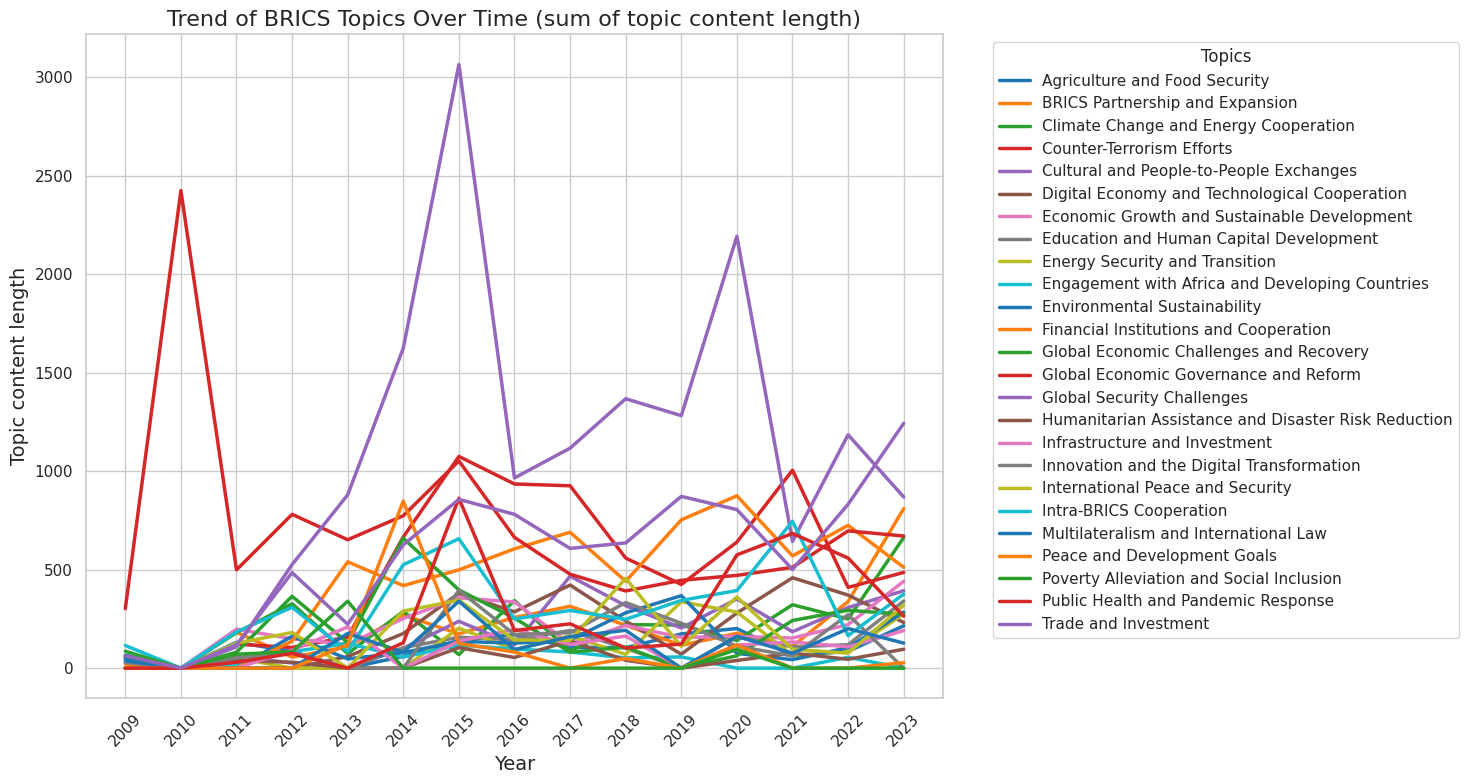

In [51]:


# Plotting the trends of each topic over time
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", palette="tab10")
for column in pivot_len_data.columns:
    sns.lineplot(data=pivot_len_data, x=pivot_len_data.index, y=column, label=column,  linewidth=2.5)
plt.title("Trend of BRICS Topics Over Time (sum of topic content length)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Topic content length", fontsize=14)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plot_file_path = '/data/chuang/temp/charts/Overall_by_content_length.png'
plt.savefig(plot_file_path)

plt.show()

In [50]:
sns.set(style="whitegrid", palette="tab10")

# Iterating through each column to create separate charts
for column in pivot_len_data.columns:
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=pivot_len_data, x=pivot_len_data.index, y=column, linewidth=2.5)
    plt.title(f"Trend of '{column}' Over Time (Sum of topic content length)", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Topic content length", fontsize=14)
    plt.xticks(rotation=45)
    #plt.show()
    # File path for each plot
    file_name = f"/data/chuang/temp/charts/{column.replace(' ', '_').replace('/', '_')}_plot.png"
    plt.savefig(file_name)

    # Close the plot to avoid overlap
    plt.close()